# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

Seed set to 8


--------
### 実験設定

In [2]:
SAMPLE_SIZE = 100  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
N_TRIALS = 1000  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 10  # 誤差分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
ALLOCATION_LIST = ["ProportionalAllocation", "PostStratification", "OptimalAllocation"]
ALLOCATION_LIST_AND_RANDOM = [
    "RandomAllocation",
    "ProportionalAllocation",
    "PostStratification",
    "OptimalAllocation",
]
CRITERION_LIST = ["ml", "none"]  # ["ml", "tr", "sil", "none"]
CLUSTERING_METHOD_LIST = ["xmeans", "kmeans"]  # ["gmm", "kmeans", "xmeans"]

SELECTING_FEATURES = (
    "all_features"  # "all_features" or "not_all_features" #特徴量を最大数選ぶかどうか
)

# クラスタ数を固定する場合（Kmeans, GMM)
N_CLUSTERS = 2  # クラスタ数(固定の場合)

# クラスタ数を固定しない場合(xmeans)
K_MIN = 2  # 最小クラスタ数
K_MAX = 10  # 最大クラスタ数

MAXIMUM_FEATURES_TO_SELECT = 10  # 選択される最大の特徴量数

stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))
METHODS_NAME_DICT = {}
for method in stratification_methods:
    if method == ("none", "kmeans"):
        METHODS_NAME_DICT[method] = "K-means"
    if method == ("none", "xmeans"):
        METHODS_NAME_DICT[method] = "X-means"
    if method == ("none", "gmm"):
        METHODS_NAME_DICT[method] = "GMM"
    if method == ("ml", "kmeans"):
        METHODS_NAME_DICT[method] = "FSS-Kmeans-ml"
    if method == ("ml", "xmeans"):
        METHODS_NAME_DICT[method] = "FSS-Xmeans-ml"
    if method == ("ml", "gmm"):
        METHODS_NAME_DICT[method] = "FSS-GMM-ml"
    if method == ("tr", "kmeans"):
        METHODS_NAME_DICT[method] = "FSS-Kmeans-tr"
    if method == ("tr", "xmeans"):
        METHODS_NAME_DICT[method] = "FSS-Xmeans-tr"
    if method == ("tr", "gmm"):
        METHODS_NAME_DICT[method] = "FSS-GMM-tr"
    if method == ("sil", "kmeans"):
        METHODS_NAME_DICT[method] = "FSS-Kmeans-silhouette"
    if method == ("sil", "xmeans"):
        METHODS_NAME_DICT[method] = "FSS-Xmeans-silouette"
    if method == ("sil", "gmm"):
        METHODS_NAME_DICT[method] = "FSS-GMM-silouette"
print("METHODS_NAME_DICT", METHODS_NAME_DICT)

METHODS_NAME_DICT {('ml', 'xmeans'): 'FSS-Xmeans-ml', ('ml', 'kmeans'): 'FSS-Kmeans-ml', ('none', 'xmeans'): 'X-means', ('none', 'kmeans'): 'K-means'}


-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(df, obj)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

-------------
### Wrapper法でクラスタリング

##### Wrapper Class
pyclustering の xmeans は　numpyのダウングレードが必要だったためscikit-learn を使用してxmeans関数を作成

In [6]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: str,
        n_clusters: int,
        criterion: str = "ml",
        clustering_method: str = "gmm",
        random_state: int = 0,
        selecting_features: str = "all_features",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select  # 特徴量数
        self.n_clusters = n_clusters  # クラスタ数
        self.criterion = criterion  # 特徴量選択基準
        self.clustering_method = clustering_method  # クラスタリング手法
        self.random_state = random_state
        self.selecting_features = selecting_features
        self.k_min = k_min
        self.k_max = k_max

    def compute_bic(self, X, kmeans):
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X):
        kmeans = KMeans(n_clusters=self.k_min)  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Wrapper":
        X, y = check_X_y(X, y)

        n_features = X.shape[1]  # 総特徴量数
        self.selected_features_ = []  # ここに選択した特徴量を入れる
        features_score_dict = {}  # 確認用

        # 選ばれた特徴量と残っている特徴量の初期化
        current_features = []
        remaining_features = list(range(n_features))
        if self.selecting_features == "not_all_features":
            best_score = -np.inf

        while len(current_features) < self.maximum_features_to_select:
            if self.selecting_features == "all_features":
                best_score = -np.inf
                best_labels = [-1 for i in range(len(X))]
                best_n_clusters = -1
            best_feature = None  # 選ぶ特徴量の初期化

            for feature in remaining_features:
                temp_features = tuple(
                    current_features + [feature]
                )  # 特徴量をひとつ加え、score計算
                score, labels, n_clusters = self.crit(X[:, temp_features])
                if score > best_score:
                    best_score = score
                    best_feature = feature
                    best_labels = labels
                    best_n_clusters = n_clusters

            if best_feature is not None:
                current_features.append(
                    best_feature
                )  # best feature をcurrent features に追加
                num_of_features = len(current_features)
                features_score = best_score
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    features_score,
                    "best_n_clusters:",
                    best_n_clusters,
                )

                features_score_dict[str(num_of_features)] = features_score  # 確認用

                remaining_features.remove(best_feature)
                self.selected_features_ = current_features
            else:
                break

        self.final_cluster_assignments_ = best_labels
        self.final_n_clusters = best_n_clusters
        self.features_score_dict = features_score_dict  # 確認用

        return self

    def crit(self, X: pd.DataFrame) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            gmm = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
            gmm.fit(X)
            labels = gmm.predict(X)
            n_clusters = len(np.unique(labels))

            if self.criterion == "tr":
                means = gmm.means_  # 平均ベクトル
                covariances = (
                    gmm.covariances_ + 1e-7
                )  # 共分散行列(各要素に微小な数が加算される)
                weights = gmm.weights_  # 混合比率
                overall_mean = np.sum(
                    weights[:, np.newaxis] * means, axis=0
                )  # 標本平均 #np.newaxisを使って1次元配列から2次元配列にする

                S_W = np.sum(weights[:, np.newaxis, np.newaxis] * covariances, axis=0)
                S_B = np.sum(
                    weights[:, np.newaxis, np.newaxis]
                    * np.einsum(
                        "...i,...j->...ij", means - overall_mean, means - overall_mean
                    ),
                    axis=0,
                )
                score = np.trace(np.linalg.solve(S_W, S_B))

            elif self.criterion == "ml":
                score = gmm.score(X)

            elif self.criterion == "sil":
                score = silhouette_score(X, labels)

        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            kmeans = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
            kmeans.fit(X)
            labels = kmeans.predict(X)
            n_clusters = len(np.unique(labels))

            if self.criterion == "tr":
                cluster_centers = kmeans.cluster_centers_

                sw_i_list = []
                for i in range(n_clusters):
                    cluster_points = X[labels == i]

                    if cluster_points.shape[0] <= 2:
                        # データポイントが1つの場合はゼロ行列を使用
                        sw_i = np.zeros((X.shape[1], X.shape[1])) + 1e-7
                    else:
                        sw_i = (np.cov(cluster_points, rowvar=False) + 1e-7) * np.sum(
                            labels
                            == i  # データ数を重みに使う代わりにデータの割合を使う
                        )
                        if np.isscalar(sw_i):  # スカラー値のとき
                            sw_i = np.array([[sw_i]])
                    sw_i_list.append(sw_i)

                # 全クラスターの S_W を合計
                S_W = np.sum(sw_i_list, axis=0)

                # クラスター間散布行列 S_B を計算
                overall_mean = np.mean(X, axis=0)
                S_B = sum(
                    (np.sum(labels == i) / X.shape[0])  # 割合にする
                    * np.outer(
                        cluster_centers[i] - overall_mean,
                        cluster_centers[i] - overall_mean,
                    )
                    # *(cluster_centers[i] - overall_mean) @ (cluster_centers[i] - overall_mean).T
                    for i in range(n_clusters)
                )

                # 散乱分離性を計算
                score = np.trace(np.linalg.solve(S_W, S_B))

            elif self.criterion == "ml":
                score = -kmeans.score(X)

            elif self.criterion == "sil":
                score = silhouette_score(X, labels)

        if self.clustering_method == "xmeans":
            xmeans = self.xmeans(X)
            xmeans.fit(X)
            labels = xmeans.labels_
            n_clusters = len(np.unique(labels))

            if self.criterion == "tr":
                cluster_centers = xmeans.cluster_centers_

                sw_i_list = []
                for i in range(n_clusters):
                    cluster_points = X[labels == i]

                    if cluster_points.shape[0] <= 2:
                        # データポイントが1つの場合はゼロ行列を使用
                        sw_i = np.zeros((X.shape[1], X.shape[1])) + 1e-7
                    else:
                        sw_i = (np.cov(cluster_points, rowvar=False) + 1e-7) * np.sum(
                            labels
                            == i  # データ数を重みに使う代わりにデータの割合を使う
                        )
                        if np.isscalar(sw_i):  # スカラー値のとき
                            sw_i = np.array([[sw_i]])
                    sw_i_list.append(sw_i)

                # 全クラスターの S_W を合計
                S_W = np.sum(sw_i_list, axis=0)

                # クラスター間散布行列 S_B を計算
                overall_mean = np.mean(X, axis=0)
                S_B = sum(
                    (np.sum(labels == i) / X.shape[0])  # 割合にする
                    * np.outer(
                        cluster_centers[i] - overall_mean,
                        cluster_centers[i] - overall_mean,
                    )
                    # *(cluster_centers[i] - overall_mean) @ (cluster_centers[i] - overall_mean).T
                    for i in range(n_clusters)
                )

                # 散乱分離性を計算
                score = np.trace(np.linalg.solve(S_W, S_B))

            elif self.criterion == "ml":
                score = -xmeans.score(X)

            elif self.criterion == "sil":
                score = silhouette_score(X, labels)

        return score, labels, n_clusters

    def get_feature_index_out(self) -> NDArray:
        return np.array(self.selected_features_)  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> NDArray:
        return self.final_cluster_assignments_  # 最終的なクラスタリング結果

    def get_features_score_dict(self) -> dict:
        return self.features_score_dict

    def get_final_n_clusters(self) -> int:
        return self.final_n_clusters

##### Wrapper classでクラスタリングしたとき

[ FSS-Xmeans-ml ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Po

num_of_features: 1 current_features: [4] , score: 4289.622293434016 best_n_clusters: 9
num_of_features: 2 current_features: [4, 1] , score: 31858.63686588239 best_n_clusters: 9
num_of_features: 3 current_features: [4, 1, 5] , score: 69235.1078826224 best_n_clusters: 10
num_of_features: 4 current_features: [4, 1, 5, 0] , score: 122638.58423307927 best_n_clusters: 9
num_of_features: 5 current_features: [4, 1, 5, 0, 12] , score: 167165.37605904776 best_n_clusters: 10
num_of_features: 6 current_features: [4, 1, 5, 0, 12, 9] , score: 245632.92062778512 best_n_clusters: 9
num_of_features: 7 current_features: [4, 1, 5, 0, 12, 9, 15] , score: 292832.4032055842 best_n_clusters: 10
num_of_features: 8 current_features: [4, 1, 5, 0, 12, 9, 15, 13] , score: 366093.837687699 best_n_clusters: 9
num_of_features: 9 current_features: [4, 1, 5, 0, 12, 9, 15, 13, 3] , score: 388690.1599085949 best_n_clusters: 9
num_of_features: 10 current_features: [4, 1, 5, 0, 12, 9, 15, 13, 3, 10] , score: 465338.718623

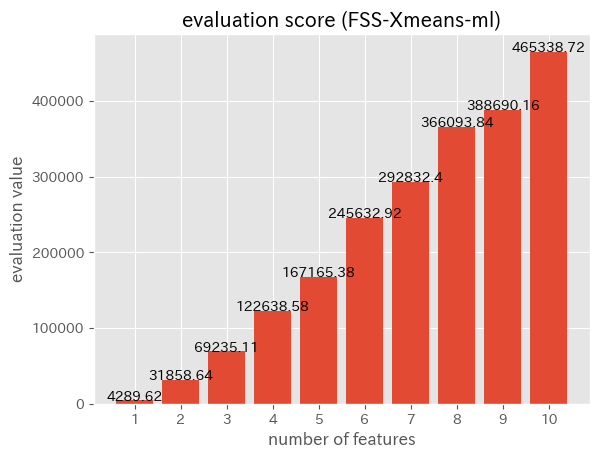

[ FSS-Kmeans-ml ]
num_of_features: 1 current_features: [5] , score: 55368.11624658386 best_n_clusters: 2
num_of_features: 2 current_features: [5, 12] , score: 150792.40485993458 best_n_clusters: 2
num_of_features: 3 current_features: [5, 12, 15] , score: 239691.76283060305 best_n_clusters: 2
num_of_features: 4 current_features: [5, 12, 15, 7] , score: 338440.2339695111 best_n_clusters: 2
num_of_features: 5 current_features: [5, 12, 15, 7, 1] , score: 446851.64064913004 best_n_clusters: 2
num_of_features: 6 current_features: [5, 12, 15, 7, 1, 6] , score: 518422.0563958344 best_n_clusters: 2
num_of_features: 7 current_features: [5, 12, 15, 7, 1, 6, 2] , score: 614195.8552272198 best_n_clusters: 2
num_of_features: 8 current_features: [5, 12, 15, 7, 1, 6, 2, 11] , score: 683086.1696206365 best_n_clusters: 2
num_of_features: 9 current_features: [5, 12, 15, 7, 1, 6, 2, 11, 8] , score: 751922.7782837354 best_n_clusters: 2
num_of_features: 10 current_features: [5, 12, 15, 7, 1, 6, 2, 11, 8, 0]

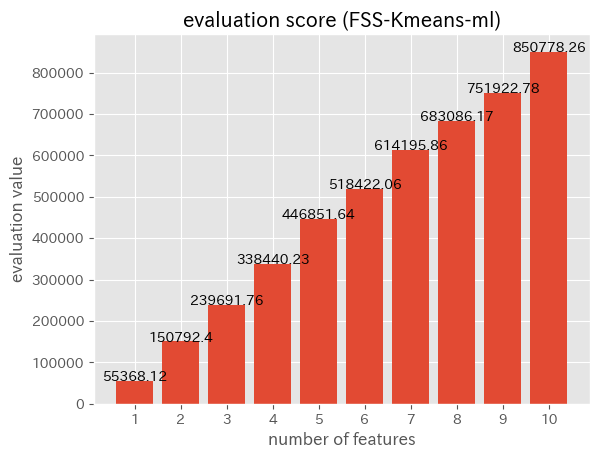

In [7]:
# Wrapper法を実装するための関数
def process_wrapper(name: str, instance: "Wrapper", X: pd.DataFrame, y: pd.DataFrame):
    instance.fss(X, y)
    selected_features_index = instance.get_feature_index_out()
    cluster_label = instance.get_final_cluster_assignments()
    cluster_size = np.unique(cluster_label, return_counts=True)[1]
    features_score_dict = instance.get_features_score_dict()
    n_clusters = instance.get_final_n_clusters()

    return (
        selected_features_index,
        cluster_label,
        cluster_size,
        features_score_dict,
        n_clusters,
    )


# Wrapperインスタンスのリスト
instances = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] != "none":
        instances.append(
            (
                name,
                Wrapper(
                    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                    n_clusters=N_CLUSTERS,
                    criterion=method[0],
                    clustering_method=method[1],
                    random_state=RANDOM_STATE,
                    selecting_features=SELECTING_FEATURES,
                    k_min=K_MIN,
                    k_max=K_MAX,
                ),
            )
        )


# 辞書の初期化
selected_features_index_dict = {}
cluster_label_dict = {}
cluster_size_dict = {}
N_CLUSTER_DICT = {}
# 各インスタンスに対して処理を実行
for name, instance in instances:
    print("[", name, "]")
    (
        selected_features_index,
        cluster_label,
        cluster_size,
        features_score_dict,
        n_clusters,
    ) = process_wrapper(name, instance, X_scaled, y)
    selected_features_index_dict[name] = selected_features_index
    cluster_label_dict[name] = cluster_label
    cluster_size_dict[name] = cluster_size
    N_CLUSTER_DICT[name] = n_clusters

    print("選択された特徴量の数 : ", len(selected_features_index))
    print("選択された特徴量のインデックス : ", selected_features_index)
    print("各層のクラスタサイズ : ", cluster_size)

    # 棒グラフを作成
    plt.bar(features_score_dict.keys(), features_score_dict.values())
    for key, value in features_score_dict.items():
        rounded_value = round(value, 2)
        plt.text(key, value + 0.3, str(rounded_value), ha="center")
    plt.title(f"evaluation score ({name})")
    plt.xlabel("number of features")
    plt.ylabel("evaluation value")
    plt.show()

##### Kmeans, GMM, Xmeansでクラスタリングしたとき

In [8]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

In [9]:
clustering_methods = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "none":
        clustering_methods.append(name)
        if method[1] == "kmeans":
            model = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
        if method[1] == "gmm":
            model = GaussianMixture(
                n_components=N_CLUSTERS, random_state=RANDOM_STATE, init_params="kmeans"
            )
        if method[1] == "xmeans":
            model = xmeans(X_scaled, k_min=K_MIN, k_max=K_MAX)
        labels = model.fit_predict(X_scaled)
        cluster_size = np.bincount(labels)
        n_clusters = len(np.unique(labels))

        cluster_label_dict[name] = labels
        cluster_size_dict[name] = cluster_size
        N_CLUSTER_DICT[name] = n_clusters

        print("[", name, "]")
        print("各層のクラスタサイズ : ", cluster_size_dict[name])
        print("クラスタラベル：", cluster_label_dict[name])
        print("クラスタ数：", N_CLUSTER_DICT[name])
        print()

[ X-means ]
各層のクラスタサイズ :  [34427 12439  9860  4660  2994  6715   264 25646   507  1570]
クラスタラベル： [3 0 7 ... 0 0 2]
クラスタ数： 10

[ K-means ]
各層のクラスタサイズ :  [29994 69088]
クラスタラベル： [0 1 1 ... 1 1 0]
クラスタ数： 2



-----------------------------
### 標本配分（Allocation)

In [10]:
print("N_CLUSTER_DICT:", N_CLUSTER_DICT)
print("cluster_label_dict", cluster_label_dict)
print("cluster_size_dict", cluster_size_dict)

N_CLUSTER_DICT: {'FSS-Xmeans-ml': 9, 'FSS-Kmeans-ml': 2, 'X-means': 10, 'K-means': 2}
cluster_label_dict {'FSS-Xmeans-ml': array([4, 4, 6, ..., 4, 0, 1]), 'FSS-Kmeans-ml': array([0, 0, 0, ..., 0, 0, 0]), 'X-means': array([3, 0, 7, ..., 0, 0, 2]), 'K-means': array([0, 1, 1, ..., 1, 1, 0])}
cluster_size_dict {'FSS-Xmeans-ml': array([12635, 14397,   507,  1090, 23267,  5437, 40692,    55,  1002],
      dtype=int64), 'FSS-Kmeans-ml': array([94195,  4887], dtype=int64), 'X-means': array([34427, 12439,  9860,  4660,  2994,  6715,   264, 25646,   507,
        1570], dtype=int64), 'K-means': array([29994, 69088], dtype=int64)}


##### 基底クラス

In [11]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        H: int,
        random_state: int,
        criterion: str,
        clustering_method: str,
        methods_name_dict: dict,
    ):
        self.sample_size = sample_size
        self.H = H
        self.random_state = random_state
        self.criterion = criterion
        self.clustering_method = clustering_method
        self.methods_name_dict = methods_name_dict

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        for method, name in self.methods_name_dict.items():
            if method[0] == self.criterion and method[1] == self.clustering_method:
                cluster_label = cluster_label_dict[name]
                cluster_size = cluster_size_dict[name]

        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size
        return cluster_label, cluster_size

##### 単純無作為抽出のクラス

In [12]:
class RandomAllocation(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])
        return n

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(
            X.shape[0]
        )  # cluster_label = [0,0,0,,...(要素数：データ数）]
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
        return cluster_label, cluster_size

##### 比例配分のクラス

In [13]:
class ProportionalAllocation(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

##### 事後層化のクラス

In [14]:
class PostStratification(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]

##### 最適標本配分のクラス

In [15]:
class OptimalAllocation(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        criterion: str = "tr",
        clustering_method: str = "kmeans",
        methods_name_dict: dict = {},
    ):
        super().__init__(
            sample_size,
            H,
            random_state,
            criterion,
            clustering_method,
            methods_name_dict,
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

##### 母平均の推定値を計算する関数

In [16]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if n[h] != 0:
            y_cluster = y[cluster_label == h]
            if n[h] <= len(y_cluster):
                sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new_labels = np.unique(n_label)
    for h in n_new_labels:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

##### 各ポリシーを生成

In [17]:
# 各ポリシーの生成を行う関数
def create_policies(
    methods_name_dict: dict,
    allocation_list: list,
    sample_size: int,
    H_dict: dict,
    random_state: int,
    m_value: int,
):  # -> dict[list[str] : list[BaseAllocation]]:
    policies_dict = {}
    for method, name in methods_name_dict.items():
        policies: list[BaseAllocation] = [
            RandomAllocation(
                sample_size=sample_size,
                H=H_dict[name],
                random_state=random_state,
                criterion=method[0],
                clustering_method=method[1],
                methods_name_dict=methods_name_dict,
            )
        ]
        if "ProportionalAllocation" in allocation_list:
            policies.append(
                ProportionalAllocation(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "PostStratification" in allocation_list:
            policies.append(
                PostStratification(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "OptimalAllocation" in allocation_list:
            policies.append(
                OptimalAllocation(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    m=np.full(H_dict[name], m_value),
                    M=None,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        policies_dict[name] = policies
    return policies_dict

----------------
### 母平均の推定と分散の計算

##### 結果の出力

In [18]:
policies_dict = create_policies(
    methods_name_dict=METHODS_NAME_DICT,
    allocation_list=ALLOCATION_LIST,
    sample_size=SAMPLE_SIZE,
    H_dict=N_CLUSTER_DICT,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
)

print("policies_dict", policies_dict)

policies_dict {'FSS-Xmeans-ml': [<__main__.RandomAllocation object at 0x000002833B09DBB0>, <__main__.ProportionalAllocation object at 0x0000028337CCAFF0>, <__main__.PostStratification object at 0x00000283379A5E80>, <__main__.OptimalAllocation object at 0x00000283374D5A30>], 'FSS-Kmeans-ml': [<__main__.RandomAllocation object at 0x000002833B132810>, <__main__.ProportionalAllocation object at 0x000002833B1BA150>, <__main__.PostStratification object at 0x000002833B1B9A30>, <__main__.OptimalAllocation object at 0x000002833B1B9520>], 'X-means': [<__main__.RandomAllocation object at 0x000002833B1BA1B0>, <__main__.ProportionalAllocation object at 0x000002833B1BAE10>, <__main__.PostStratification object at 0x000002833B1BB0B0>, <__main__.OptimalAllocation object at 0x000002833B104650>], 'K-means': [<__main__.RandomAllocation object at 0x000002833B1046B0>, <__main__.ProportionalAllocation object at 0x000002833B105730>, <__main__.PostStratification object at 0x000002833B105250>, <__main__.Optimal

In [19]:
allocations_dict = {}
for name, policies in policies_dict.items():
    # それぞれの戦略で各クラスタの標本数を求解
    allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
    for policy in policies:
        # policyを用いてXをクラスタリング
        cluster_label, _ = policy.clustering(X_scaled)
        n = policy.solve(X_scaled, y)
        allocations.append(
            {
                "policy": policy.__class__.__name__,
                "n": n,
                "cluster_label": cluster_label,
            }
        )
    allocations_dict[name] = allocations

In [20]:
def cauculate_reduction_rate(
    X: pd.DataFrame, y: pd.DataFrame, policies_dict: dict
) -> dict:
    reduction_rate_dict = {}
    error_variance_dict = {}

    # 各戦略の標本数に基づいて目的変数の平均を推定
    y_hats_dict = {}
    for name, allocations in allocations_dict.items():
        y_hats = []
        for random_state in range(N_TRIALS):
            for allocation in allocations:
                if allocation["policy"] == "PostStratification":
                    y_hat = estimate_y_mean_post(
                        allocation["n"], allocation["cluster_label"], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation["n"], allocation["cluster_label"], y
                    )
                y_hats.append(
                    {
                        "policy": allocation["policy"],
                        "y_hat": y_hat,
                        "random_state": random_state,
                    }
                )
        y_hats_dict[name] = y_hats

    for name, y_hats in y_hats_dict.items():
        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        # random_allocationの誤差分散
        random_allocation_std = y_hat_df[y_hat_df["policy"] == "RandomAllocation"][
            "error"
        ].var()
        # random_allocation以外の誤差分散
        non_random_allocation_std = (
            y_hat_df[y_hat_df["policy"] != "RandomAllocation"]
            .groupby("policy")["error"]
            .var()
        )

        # 削減率
        reduction_rate = (1 - non_random_allocation_std / random_allocation_std) * 100

        ## policyの順番をpoliciesの順番に調整
        reduction_rate = reduction_rate.reindex(
            [policy.__class__.__name__ for policy in policies]
        )

        error_variance = pd.concat(
            [
                pd.Series(random_allocation_std, index=["RandomAllocation"]),
                non_random_allocation_std,
            ]
        )

        reduction_rate_dict[name] = reduction_rate
        error_variance_dict[name] = error_variance
    return reduction_rate_dict, error_variance_dict

In [21]:
all_reduction_rate = []
all_error_variance = []
for i in range(N_EXPERIMENT):
    reduction_rate_dict, error_variance_dict = cauculate_reduction_rate(
        X_scaled, y, policies_dict
    )
    all_reduction_rate.append(reduction_rate_dict)
    all_error_variance.append(error_variance_dict)

In [22]:
results_reduction_rate = {}
results_error_variance = {}
results_list = [results_reduction_rate, results_error_variance]
all_results = [all_reduction_rate, all_error_variance]

for i in range(2):
    for method, name in METHODS_NAME_DICT.items():
        results_list[i][name] = {}
        for allocation_method in ALLOCATION_LIST:
            results_list[i][name][allocation_method] = []
    for dict in all_results[i]:
        for name, policy in dict.items():
            for allocation_method in ALLOCATION_LIST:
                results_list[i][name][allocation_method].append(
                    policy[allocation_method]
                )

mean_results_reduction_rate = {}
mean_results_error_variance = {}
mean_results_list = [mean_results_reduction_rate, mean_results_error_variance]


for i in range(2):
    for method, name in METHODS_NAME_DICT.items():
        mean_results_list[i][name] = {}
        for allocation_method in ALLOCATION_LIST:
            mean_results_list[i][name][allocation_method] = []
    for name, dict in results_list[i].items():
        for allocation_method in ALLOCATION_LIST:
            mean_results_list[i][name][allocation_method] = np.mean(
                np.array(dict[allocation_method])
            )

print(results_reduction_rate)
print(mean_results_reduction_rate)
print(results_error_variance)
print(mean_results_error_variance)

{'FSS-Xmeans-ml': {'ProportionalAllocation': [1.9637031041379371, 25.77214345423393, 11.05723091534998, 5.6443964819463455, 7.507143510023829, 15.012555503775927, 16.91480807050121, 15.860743397336751, 4.430390552563878, 25.683038915226643], 'PostStratification': [-4.0714006077245735, 22.16904141431588, 12.080525262324581, 1.3064641370404972, 9.463159935136567, 11.79067551270755, 3.3770564089723343, 15.98194938423223, 6.282515066245287, 21.84218570274966], 'OptimalAllocation': [14.716652547169529, 30.835386456995863, 20.183676973532762, 17.29522658723259, 25.870972136418256, 23.83180909748305, 18.78030583908934, 16.445927887145807, 12.760707705775676, 33.18142165192175]}, 'FSS-Kmeans-ml': {'ProportionalAllocation': [1.474977679666989, 1.2435461989927954, 3.063475421207007, -7.708995401373464, -6.330937500298073, 12.838204996954094, 7.511516737112345, -2.4538079629212506, 8.038219993820771, -6.781383846241917], 'PostStratification': [-17.57163357260636, -17.642695607880565, -7.064735420

##### 分散削減率の可視化

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has

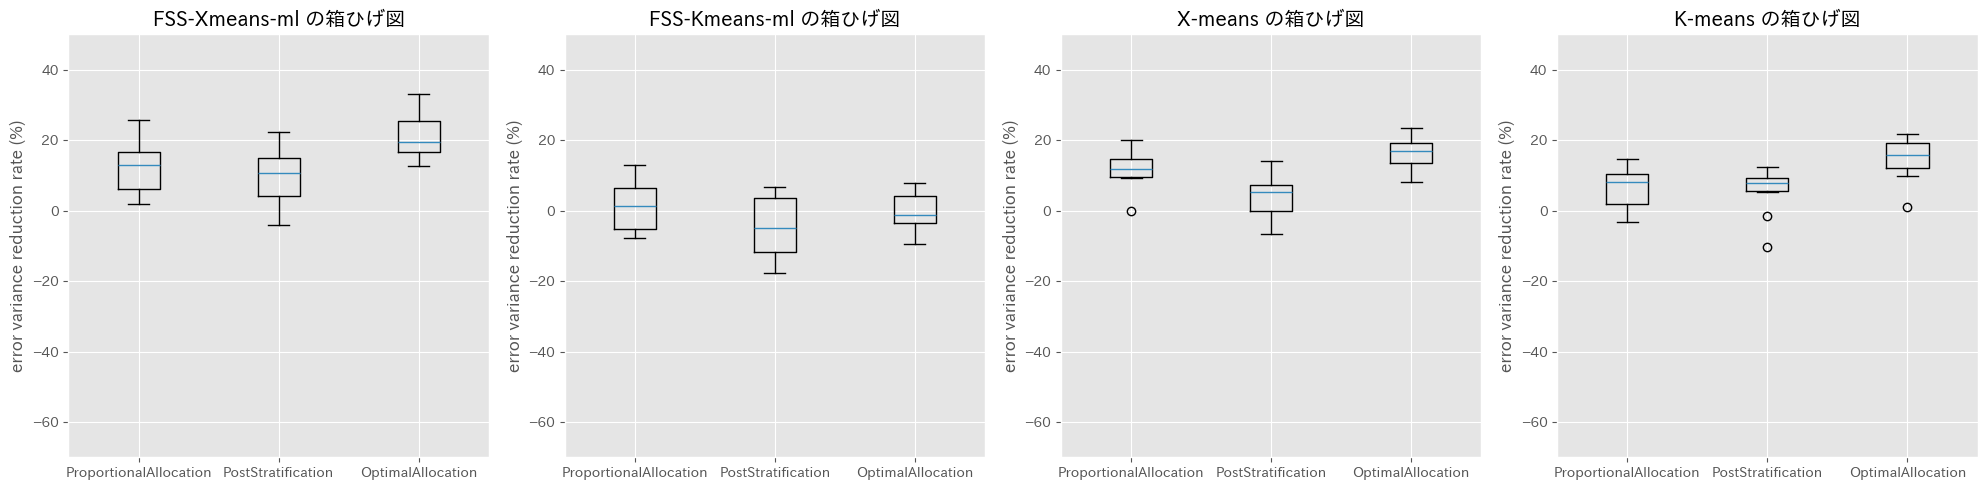

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_22688\4159511362.py:44: MatplotlibDeprecationWarning: The 'l

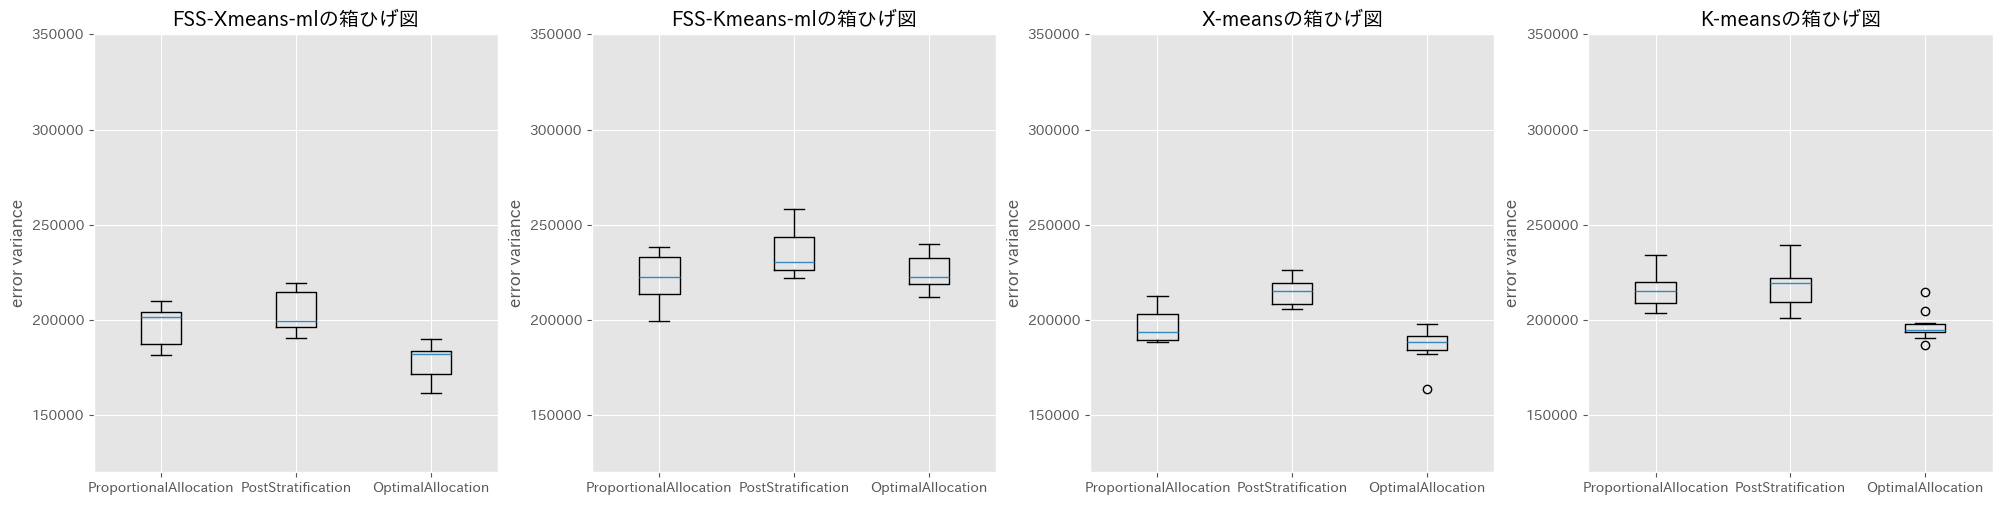

In [23]:
# 誤差分散削減率の箱ひげ図
fig, axs = plt.subplots(
    1, len(results_reduction_rate), figsize=(20, 5)
)  # サブプロットを作成
if isinstance(axs, np.ndarray):
    ax = axs[i]  # 複数サブプロットの場合
else:
    ax = axs  # サブプロットが1つの場合はそのまま


# 各methodに対して
plot_idx = 0  # サブプロットのインデックス
for i, (method, allocations) in enumerate(results_reduction_rate.items()):
    allo_data = list(allocations.values())  # allo1, allo2, allo3 のデータリスト
    allo_labels = list(allocations.keys())  # alloのラベルリスト
    # 箱ひげ図をプロット
    ax = axs[plot_idx]
    ax.boxplot(allo_data, labels=allo_labels)
    # グラフタイトルを設定
    ax.set_title(f"{method} の箱ひげ図")
    ax.set_ylabel("error variance reduction rate (%)")
    ax.set_ylim(-70, 50)
    plot_idx += 1

# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()


# 誤差分散の箱ひげ図
fig, axs = plt.subplots(
    1, len(results_error_variance), figsize=(20, 5)
)  # サブプロットを作成
if isinstance(axs, np.ndarray):
    ax = axs[i]  # 複数サブプロットの場合
else:
    ax = axs  # サブプロットが1つの場合はそのまま

plot_idx = 0  # サブプロットのインデックス
for i, (method, allocations) in enumerate(results_error_variance.items()):
    allo_data = list(allocations.values())  # allo1, allo2, allo3 のデータリスト
    allo_labels = list(allocations.keys())  # alloのラベルリスト
    ax = axs[plot_idx]  # 現在のサブプロットを取得
    ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
    ax.set_title(f"{method}の箱ひげ図")  # タイトル設定
    ax.set_ylabel("error variance")
    ax.set_ylim(120000, 350000)
    plot_idx += 1  # 次のサブプロットへ移動

# レイアウト調整して表示
plt.rcParams["font.size"] = 5
plt.tight_layout()
plt.show()

['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[12.984615390509642, 10.0222172216, 21.39020868827646]
['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[1.0894816316919296, -4.8897948437975165, -0.2539829574165674]
['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[11.979372389924643, 3.85866780858464, 16.607610236928853]
['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[6.534419079432672, 5.608516168154027, 14.489822818568655]


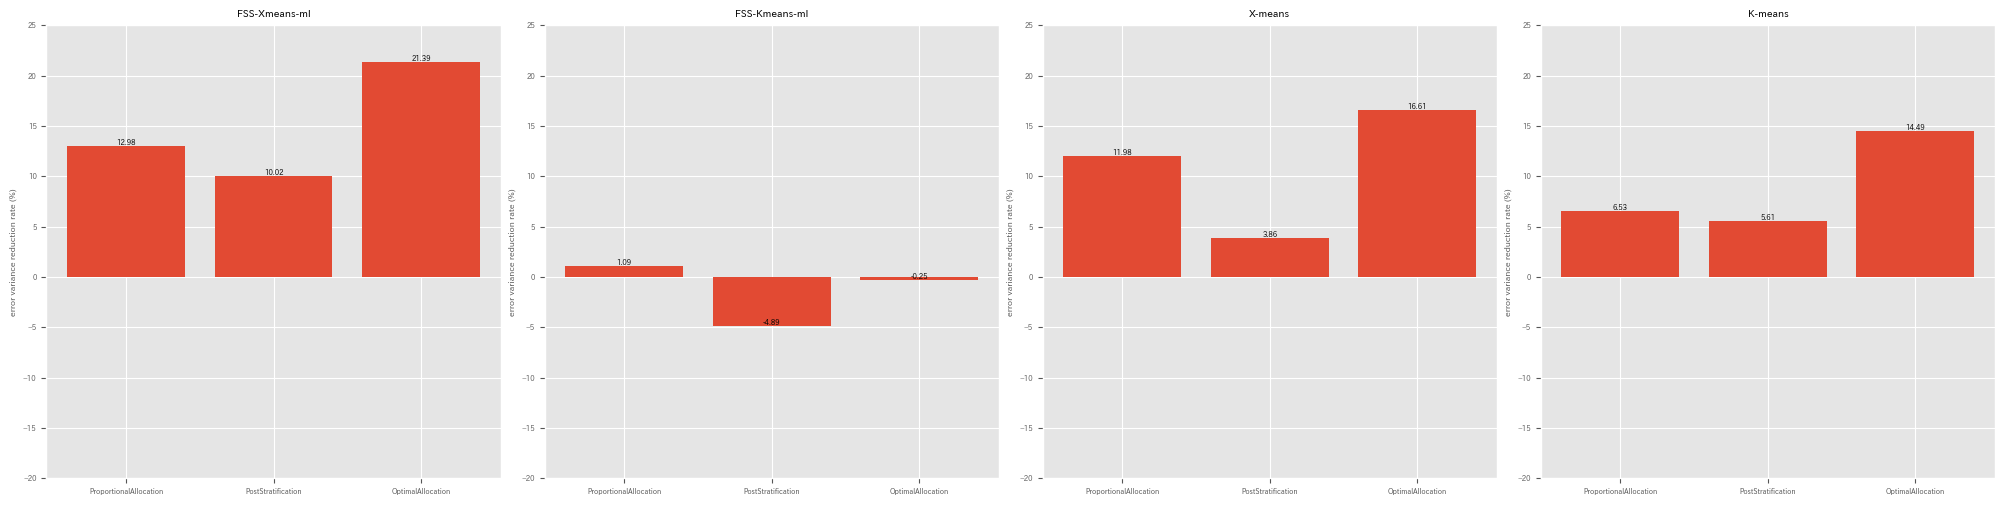

['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[197045.2290239099, 203838.22262113093, 178154.08422698785]
['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[222000.56546381032, 235091.30136501725, 225010.80470832507]
['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[196912.79628509007, 214980.36360018118, 186714.5698780623]
['ProportionalAllocation', 'PostStratification', 'OptimalAllocation']
[215553.904420602, 217697.44477835056, 197077.16327369522]


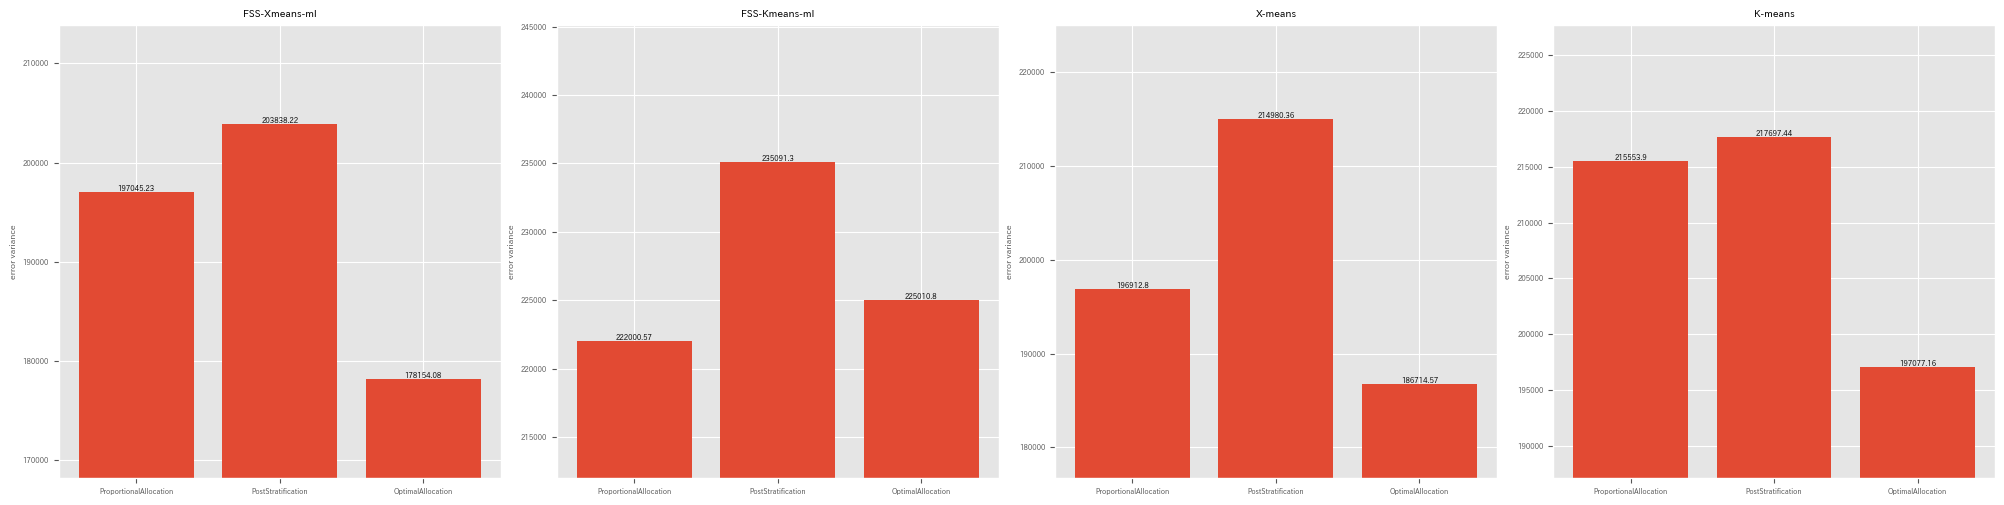

In [24]:
# グラフ作成
fig, axs = plt.subplots(
    1, len(mean_results_reduction_rate), figsize=(20, 5)
)  # サブプロットを作成
if isinstance(axs, np.ndarray):
    ax = axs[i]  # 複数サブプロットの場合
else:
    ax = axs  # サブプロットが1つの場合はそのまま

plot_idx = 0
for method, dict in mean_results_reduction_rate.items():
    x = [a for a in ALLOCATION_LIST]
    values = [val for val in mean_results_reduction_rate[method].values()]  # y軸
    print(x)
    print(values)
    ax = axs[plot_idx]
    bars = ax.bar(x, values)
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
        )  # 値をバーの上に表示
        # plt.ylabel("誤差分散削減率 (%)")
    ax.set_ylabel("error variance reduction rate (%)")
    ax.set_ylim(-20, 25)
    ax.set_title(method)  # (number of clusters: {clusters})")
    plot_idx += 1

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1, len(mean_results_error_variance), figsize=(20, 5)
)  # サブプロットを作成
if isinstance(axs, np.ndarray):
    ax = axs[i]  # 複数サブプロットの場合
else:
    ax = axs  # サブプロットが1つの場合はそのまま

plot_idx = 0
for method, dict in mean_results_reduction_rate.items():
    x = [a for a in ALLOCATION_LIST]
    values = [val for val in mean_results_error_variance[method].values()]  # y軸
    print(x)
    print(values)
    ax = axs[plot_idx]
    bars = ax.bar(x, values)
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
        )  # 値をバーの上に表示
        # plt.ylabel("誤差分散削減率 (%)")
    ax.set_ylabel("error variance")
    ax.set_ylim(min(values) - 10000, max(values) + 10000)
    ax.set_title(method)
    plot_idx += 1

plt.tight_layout()
plt.show()